In [1]:
#@title Setup (may take a few minutes)
import os


# !pip install accelerate
# !pip install diffusers
# !pip install transformers
# !pip install kornia==0.6.11
# !pip install pyrallis==0.3.1



import torch

import os
from pathlib import Path
import torch.utils.checkpoint
import itertools
from accelerate import Accelerator
from diffusers import StableDiffusionPipeline
import prompt_dataset
import utils
from inet_classes import IDX2NAME as IDX2NAME_INET

import shutil
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials
#Authenticate and create the PyDrive client.
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

C:\Users\ozzafar\AppData\Local\anaconda3\envs\cudatest\Lib\site-packages\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
C:\Users\ozzafar\AppData\Local\anaconda3\envs\cudatest\Lib\site-packages\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(



# Hyperparameters

In [2]:
class_index: int = 283 #@param {type:"number"}

classifier: str = 'clip-count' #@param ['inet', 'inat', 'cub','clip','clip-count'] {type:"string"}

_lambda: float = 1  #@param {type:"number"}
scale: float = 70 # 80  #@param {type:"number"}

# Affect training time
early_stopping: int = 15 #@param {type:"integer"}
num_train_epochs: int = 50 #@param {type:"integer"}

# affect variability of the training images
# i.e., also sets batch size with accumulation
epoch_size: int = 1 #@param {type:"integer"}
number_of_prompts: int = 1 #@param {type:"integer"}
batch_size: int = 1 #@param {type:"integer"}
gradient_accumulation_steps: int = 1 #@param {type:"integer"}

# Skip if there exists a token checkpoint
skip_exists: bool = False #@param {type:"boolean"}

# Train and Optimization
lr: float = 0.00125  #@param {type:"number"}
betas1: tuple = 0.9 #@param {type:"number"}
betas2: tuple = 0.999 #@param {type:"number"}
betas = (betas1, betas2)


weight_decay: float = 1e-2 #@param {type:"number"}
eps: float = 1e-08 #@param {type:"number"}
max_grad_norm: str = "1" #@param {type:"string"}
seed: int = 35 #@param {type:"integer"}

# Generative model
guidance_scale: int = 7 #@param {type:"integer"}
height: int = 512 #@param {type:"integer"}
width: int = 512 #@param {type:"integer"}
num_of_SD_inference_steps: int = 35 #@param {type:"integer"}
num_of_SD_backpropagation_steps: int = 1 #@param {type:"integer"}

# Discriminative tokens
placeholder_token: str = "newclas" #@param {type:"string"}
initializer_token: str = "a" #@param {type:"string"}

# Path to save all outputs to
output_path: str = "results" #@param {type:"string"}
save_as_full_pipeline: bool = True #@param {type:"boolean"}

# Cuda related
device: str = "cuda" #@param {type:"string"}
mixed_precision: str = "no" #@param ["fp16", "fp32"] {type:"string"}
gradient_checkpointing: bool = True #@param {type:"boolean"}

# evaluate
test_size: int = 3 #@param {type:"integer"}

In [3]:
from collections import namedtuple
# Define the configuration names
config_names = [
    "class_index",
    "classifier",
    "early_stopping",
    "num_train_epochs",
    "epoch_size",
    "number_of_prompts",
    "batch_size",
    "gradient_accumulation_steps",
    "skip_exists",
    "betas",
    "lr",
    "eps",
    "weight_decay",
    "seed",
    "max_grad_norm",
    "guidance_scale",
    "height",
    "width",
    "num_of_SD_inference_steps",
    "num_of_SD_backpropagation_steps",
    "placeholder_token",
    "initializer_token",
    "output_path",
    "save_as_full_pipeline",
    "device",
    "mixed_precision",
    "gradient_checkpointing",
    "test_size",
    "scale"
]

# Use globals() to extract values from matching variable names
config_values = [globals()[name] for name in config_names]

# Create the named tuple
Config = namedtuple("Config", config_names)
config = Config(*config_values)
config

Config(class_index=283, classifier='clip-count', early_stopping=15, num_train_epochs=50, epoch_size=1, number_of_prompts=1, batch_size=1, gradient_accumulation_steps=1, skip_exists=False, betas=(0.9, 0.999), lr=0.00125, eps=1e-08, weight_decay=0.01, seed=35, max_grad_norm='1', guidance_scale=7, height=512, width=512, num_of_SD_inference_steps=35, num_of_SD_backpropagation_steps=1, placeholder_token='newclas', initializer_token='a', output_path='results', save_as_full_pipeline=True, device='cuda', mixed_precision='no', gradient_checkpointing=True, test_size=3, scale=70)

# Train

In [4]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [5]:
# from InstaFlow.code.pipeline_rf import RectifiedFlowPipeline
# 
# generator = torch.Generator(
#     device=config.device
# )  # Seed generator to create the inital latent noise
# 
# generator.manual_seed(config.seed)
# 
# 
# pipeline = RectifiedFlowPipeline.from_pretrained(
#     "XCLIU/instaflow_0_9B_from_sd_1_5",
#     safety_checker = None,
#     torch_dtype=torch.float32
# ).to(device)
# 
# # generate image    
# image = pipeline(prompt="a photo of 7 oranges",
#     num_inference_steps=1,
#     generator=generator,
#     guidance_scale=0.0,
#     output_type="pil"
# ).images[0] 
# 
# image.show()

In [6]:
from torchvision.transforms import transforms, Compose, Resize, CenterCrop, ToTensor, Normalize
from InstaFlow.code.pipeline_rf import RectifiedFlowPipeline
import time
from transformers import CLIPProcessor
import numpy as np
import cv2
import torchvision.transforms.functional as TF
from transformers import CLIPModel
import os

os.environ['TORCH_USE_CUDA_DSA'] = "1"
torch.autograd.set_detect_anomaly(True)

def set_seed(generator):
    generator.manual_seed(config.seed)

# Classification model
classification_model = utils.prepare_classifier(config)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").cuda()

exp_identifier = (
    f'instaflow_{config.epoch_size}_{config.lr}_'
    f"{config.seed}_{config.number_of_prompts}_{config.early_stopping}_{config.num_of_SD_backpropagation_steps}_{time.strftime('%Y%m%d_%H%M%S')}"
)

#### Train ####
print(f"Start experiment {exp_identifier}")

class_name = "15 oranges"
print(f"Start training class token for {class_name}")
img_dir_path = f"img/{class_name}/train"
if Path(img_dir_path).exists():
    shutil.rmtree(img_dir_path)
Path(img_dir_path).mkdir(parents=True, exist_ok=True)

# Stable model
unet, vae, text_encoder, scheduler, tokenizer = utils.prepare_stable(config)

#  Extend tokenizer and add a discriminative token ###
class_infer = int(class_name.split()[0])
prompt_suffix = " ".join(class_name.lower().split("_"))

## Add the placeholder token in tokenizer
num_added_tokens = tokenizer.add_tokens(config.placeholder_token)
if num_added_tokens == 0:
    raise ValueError(
        f"The tokenizer already contains the token {config.placeholder_token}. Please pass a different"
        " `placeholder_token` that is not already in the tokenizer."
    )

## Get token ids for our placeholder and initializer token.
# This code block will complain if initializer string is not a single token
## Convert the initializer_token, placeholder_token to ids
token_ids = tokenizer.encode(config.initializer_token, add_special_tokens=False)
# Check if initializer_token is a single token or a sequence of tokens
if len(token_ids) > 1:
    raise ValueError("The initializer token must be a single token.")

initializer_token_id = token_ids[0]
placeholder_token_id = tokenizer.convert_tokens_to_ids(config.placeholder_token)

# we resize the token embeddings here to account for placeholder_token
text_encoder.resize_token_embeddings(len(tokenizer))

#  Initialise the newly added placeholder token
token_embeds = text_encoder.get_input_embeddings().weight.data
token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]

# Define dataloades

def collate_fn(examples):
    input_ids = [example["instance_prompt_ids"] for example in examples]
    input_ids = tokenizer.pad(
        {"input_ids": input_ids}, padding=True, return_tensors="pt"
    ).input_ids
    texts = [example["instance_prompt"] for example in examples]
    batch = {
        "texts": texts,
        "input_ids": input_ids,
    }

    return batch

train_dataset = prompt_dataset.PromptDataset(
    prompt_suffix=prompt_suffix,
    tokenizer=tokenizer,
    placeholder_token=config.placeholder_token,
    number_of_prompts=config.number_of_prompts,
    epoch_size=config.epoch_size,
)

train_batch_size = config.batch_size
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    pin_memory=True,
)

# Define optimization

## Freeze vae and unet
utils.freeze_params(vae.parameters())
utils.freeze_params(unet.parameters())

## Freeze all parameters except for the token embeddings in text encoder
params_to_freeze = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)
utils.freeze_params(params_to_freeze)

optimizer_class = torch.optim.AdamW
optimizer = optimizer_class(
    text_encoder.get_input_embeddings().parameters(),  # only optimize the embeddings
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
    eps=config.eps,
)
criterion = torch.nn.MSELoss().cuda() # TODO ozzafar torch.nn.L1Loss?

accelerator = Accelerator(
    gradient_accumulation_steps=config.gradient_accumulation_steps,
    mixed_precision=config.mixed_precision,
)

if config.gradient_checkpointing:
    text_encoder.gradient_checkpointing_enable()
    unet.enable_gradient_checkpointing()

text_encoder, optimizer, train_dataloader = accelerator.prepare(
    text_encoder, optimizer, train_dataloader
)

weight_dtype = torch.float32
if accelerator.mixed_precision == "fp16":
    weight_dtype = torch.float16
elif accelerator.mixed_precision == "bf16":
    weight_dtype = torch.bfloat16

# Move vae and unet to device
vae.to(accelerator.device, dtype=weight_dtype)
unet.to(accelerator.device, dtype=weight_dtype)

classification_model = classification_model.to(accelerator.device)
text_encoder = text_encoder.to(accelerator.device)

# Keep vae in eval mode as we don't train it
vae.eval()
# Keep unet in train mode to enable gradient checkpointing
unet.train()

global_step = 0
total_loss = 0
min_loss = 99999

# Define token output dir
token_dir_path = f"token/{class_name}"
Path(token_dir_path).mkdir(parents=True, exist_ok=True)
token_path = f"{token_dir_path}/{exp_identifier}_{class_name}"

#### Training loop ####
for epoch in range(config.num_train_epochs):
    print(f"Epoch {epoch}")
    generator = torch.Generator(
        device=config.device
    )  # Seed generator to create the inital latent noise
    generator.manual_seed(config.seed)
    correct = 0
    for step, batch in enumerate(train_dataloader):
        start = time.time()
        # setting the generator here means we update the same images
        classification_loss = None
        with accelerator.accumulate(text_encoder):

            set_seed(generator)
            
            # pipeline.text_encoder = text_encoder
            pipeline = RectifiedFlowPipeline.from_pretrained(
                "XCLIU/instaflow_0_9B_from_sd_1_5",
                safety_checker = None,
                torch_dtype=weight_dtype,
                text_encoder=text_encoder,
                vae=vae,
                unet=unet,
                tokenizer=tokenizer,
                scheduler=scheduler,
            ).to(device)
            
            # generate image            
            image = pipeline(prompt=batch['texts'][0],
                num_inference_steps=1,
                height=config.height,
                width=config.width,
                generator=generator,
                guidance_scale=0.0
            ).images[0] 

            image = image.unsqueeze(0)
            image_out = image
            image = utils.transform_img_tensor(image, config).to(device)
            
            prompt = [class_name.split()[-1]]
            
            generated_image = time.time()
            print(f"generated image in {(generated_image - start)/60} minutes")

            with torch.cuda.amp.autocast():
                orig_output = classification_model.forward(image, prompt)
            
            clip_count_end = time.time()
            print(f"clip count executed in {(clip_count_end - generated_image)/60} minutes")
    
            output = torch.sum(orig_output[0]/config.scale)
        
            if classification_loss is None:
                classification_loss = criterion(
                    output, torch.HalfTensor([class_infer]).cuda()
                )/torch.HalfTensor([class_infer]).cuda() # TODO removed power 2
            else:
                classification_loss += criterion(
                    output, torch.HalfTensor([class_infer]).cuda()
                )/torch.HalfTensor([class_infer]).cuda() # TODO removed power 2
                            
            text_inputs = processor(text=prompt, return_tensors="pt", padding=True).to(device)
            inputs = {**text_inputs, "pixel_values": image}
            clip_output = (clip(**inputs)[0][0]/100).cuda()
            clip_output = _lambda * (1-clip_output)
            
            clip_end = time.time()
            print(f"clip executed in {(clip_end - clip_count_end)/60} minutes")

            classification_loss += clip_output

            total_loss += classification_loss.detach().item()

            # log
            txt = f"On epoch {epoch} \n"
            with torch.no_grad():
                txt += f"{batch['texts']} \n"
                txt += f"{output.item()=} \n"
                txt += f"Loss: {classification_loss.detach().item()} \n"
                txt += f"Clip-Count loss: {classification_loss.detach().item()-clip_output.detach().item()} \n"
                txt += f"Clip loss: {clip_output.detach().item()}"
                with open("run_log.txt", "a") as f:
                    print(txt, file=f)
                print(txt)
                display(utils.numpy_to_pil(
                    image_out.detach().permute(0, 2, 3, 1).cpu().numpy()
                )[0])
                
                # counting prediction heatmap
                pred_density = orig_output[0].detach().cpu().numpy()
                pred_density = pred_density/pred_density.max()
                pred_density_write = 1. - pred_density
                pred_density_write = cv2.applyColorMap(np.uint8(255*pred_density_write), cv2.COLORMAP_JET)
                pred_density_write = pred_density_write/255.
                img = TF.resize(image.detach(), (384)).squeeze(0).permute(1, 2, 0).cpu().numpy()
                heatmap_pred = 0.33 * img + 0.67 * pred_density_write
                heatmap_pred = heatmap_pred/heatmap_pred.max()
                display(utils.numpy_to_pil(
                    heatmap_pred
                )[0])
                
                log_end = time.time()
                print(f"logging in {(log_end - clip_count_end)/60} minutes")

            torch.nn.utils.clip_grad_norm_(
                text_encoder.get_input_embeddings().parameters(),
                config.max_grad_norm,
            )

            start_back = time.time()
            
            accelerator.backward(classification_loss)
            
            print(f"backprog in {(time.time() - start_back)/60} minutes")

            # Zero out the gradients for all token embeddings except the newly added
            # embeddings for the concept, as we only want to optimize the concept embeddings
            if accelerator.num_processes > 1:
                grads = (
                    text_encoder.module.get_input_embeddings().weight.grad
                )
            else:
                grads = text_encoder.get_input_embeddings().weight.grad

            # Get the index for tokens that we want to zero the grads for
            index_grads_to_zero = (
                torch.arange(len(tokenizer)) != placeholder_token_id
            )
            grads.data[index_grads_to_zero, :] = grads.data[
                index_grads_to_zero, :
            ].fill_(0)

            # Checks if the accelerator has performed an optimization step behind the scenes\n",
            if step == config.epoch_size - 1:
                if total_loss > 2 * min_loss:
                    print("!!!!training collapse, try different hp!!!!")
                    # epoch = config.num_train_epochs
                    # break
                print("update")
                if total_loss < min_loss:
                    min_loss = total_loss
                    current_early_stopping = config.early_stopping
                    # Create the pipeline using the trained modules and save it.
                    accelerator.wait_for_everyone()
                    if accelerator.is_main_process:
                        print(
                            f"Saved the new discriminative class token pipeline of {class_name} to pipeline_{token_path}"
                        )
                        pipeline.save_pretrained(f"pipeline_{token_path}") # TODO unwrap text encoder accelerator
                else:
                    current_early_stopping -= 1
                print(
                    f"{current_early_stopping} steps to stop, current best {min_loss}"
                )

                total_loss = 0
                global_step += 1

            optimizer.step()
            optimizer.zero_grad()

    print(f"Current accuracy {correct / config.epoch_size}")

    if (correct / config.epoch_size > 0.7) or current_early_stopping < 0:
        break

Start experiment instaflow_1_0.00125_35_1_15_1_20240422_162114
Start training class token for 15 oranges


Couldn't connect to the Hub: 503 Server Error: Service Temporarily Unavailable for url: https://huggingface.co/api/models/XCLIU/instaflow_0_9B_from_sd_1_5.
Will try to load from local cache.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

C:\Program Files (x86)\JetBrains\PyCharm 2023.2\plugins\python\helpers\pydev\_pydevd_bundle\pydevd_xml.py:340: FutureWarning: Accessing config attribute `__len__` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access '__len__' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.__len__'.
  elif hasattr(v, '__len__') and not is_string(v):
C:\Program Files (x86)\JetBrains\PyCharm 2023.2\plugins\python\helpers\pydev\_pydevd_bundle\pydevd_xml.py:340: FutureWarning: Accessing config attribute `__len__` directly via 'AutoencoderKL' object attribute is deprecated. Please access '__len__' over 'AutoencoderKL's config object instead, e.g. 'unet.config.__len__'.
  elif hasattr(v, '__len__') and not is_string(v):


KeyboardInterrupt: 


# Eval

Evaluation - print image with discriminatory tokens, then one without.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'InstaFlow.code.pipeline_rf.RectifiedFlowPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


pipe_path='pipeline_token/15 oranges/instaflow_1_0.00125_35_1_15_1_20240422_145245_15 oranges'
Evaluation for the prompt: A photo of newclas 15 oranges


  0%|          | 0/1 [00:00<?, ?it/s]

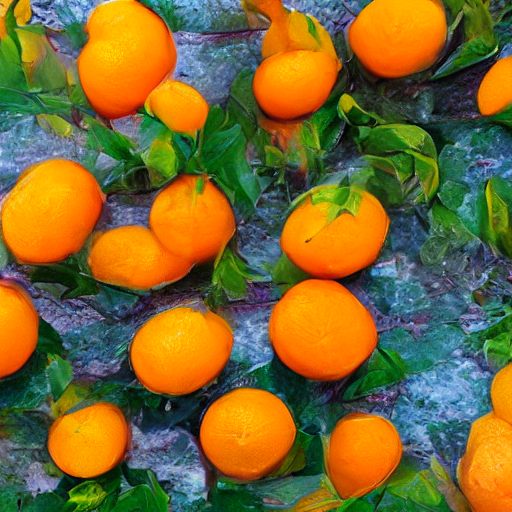

Evaluation for the prompt: A photo of a 15 oranges


  0%|          | 0/1 [00:00<?, ?it/s]

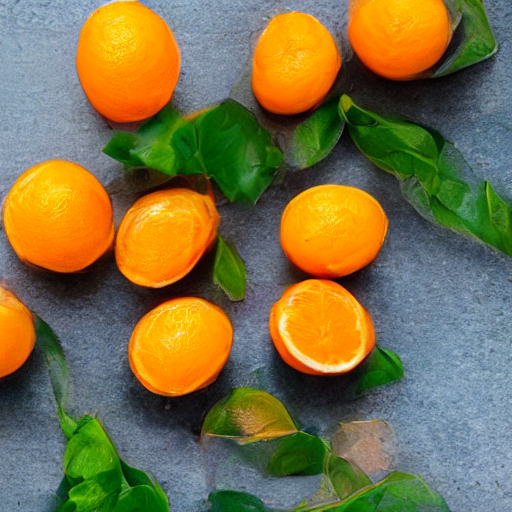

In [7]:
print("Evaluation - print image with discriminatory tokens, then one without.")
# Stable model
token_dir_path = f"token/{class_name}"
Path(token_dir_path).mkdir(parents=True, exist_ok=True)
pipe_path = f"pipeline_{token_dir_path}/{exp_identifier}_{class_name}"
pipe = RectifiedFlowPipeline.from_pretrained(pipe_path, safety_checker = None, torch_dtype=weight_dtype).to(config.device)

print(f"{pipe_path=}")

correct = dict()
correct['a'] = 0
correct[config.placeholder_token] = 0

generator = torch.Generator(device=config.device)  # Seed generator to create the initial latent noise

for descriptive_token in [config.placeholder_token,"a"]:
  generator.manual_seed(config.seed)
  prompt = f"A photo of {descriptive_token} {class_name}"
  print(f"Evaluation for the prompt: {prompt}")

  image_out = pipe(prompt, generator=generator, num_inference_steps=1, height=config.height, width=config.width, guidance_scale=0.0)[0]
  image = utils.transform_img_tensor(image_out, config)

  # output = classification_model(image).logits
  # pred_class = torch.argmax(output).item()

  display(utils.numpy_to_pil(image_out.permute(0, 2, 3, 1).cpu().detach().numpy())[0])